In [129]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import sklearn
import scipy
import PIL
import os
import tracemalloc #for testing memory efficiency


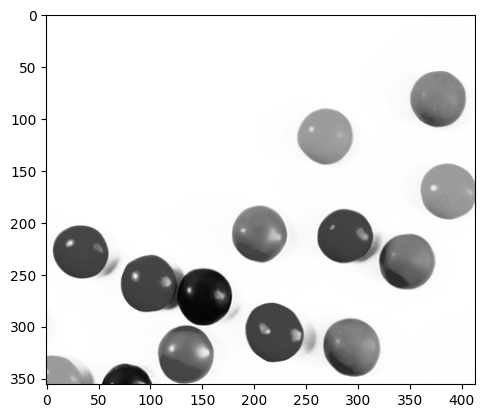

In [4]:
#Q1-1 (1)
smarties = np.array(plt.imread("./smarties.png")) #read RGB image as numpy array
smarties
#356*413*3

gray_smarties = cv2.cvtColor(smarties, cv2.COLOR_RGB2GRAY) #turn RGB to grayscale
plt.imshow(gray_smarties, cmap='gray')

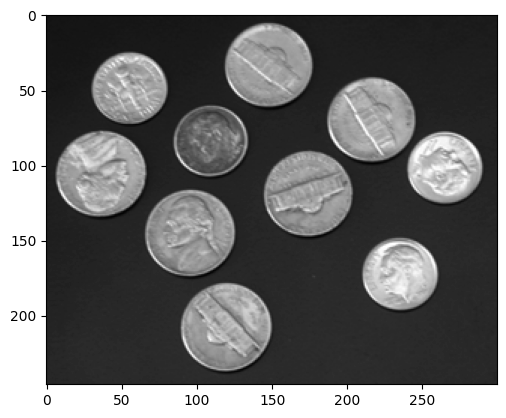

In [5]:
#Q1-1 (2)
coins = np.array(plt.imread("./coins.png"))
coins
#246*300*4

coins_gray = cv2.cvtColor(coins,cv2.COLOR_RGBA2GRAY)
plt.imshow(coins_gray, cmap='gray')

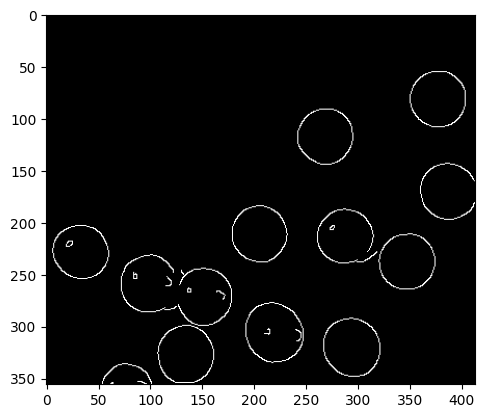

In [6]:
#Q1-2 (1)
# Convert the img from 32-bit float to 8-bit integer
gray_smarties = cv2.normalize(gray_smarties, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

# Apply Gaussian filter on the image first 
# Built-in Canny edges detection
edge_smarties = cv2.Canny(gray_smarties, 300, 500)
plt.imshow(edge_smarties, cmap = 'gray')

row = len(edge_smarties)
col = len(edge_smarties[0])
#normalization
for i in range(row):
    for j in range(col):
        edge_smarties[i, j] /= 255


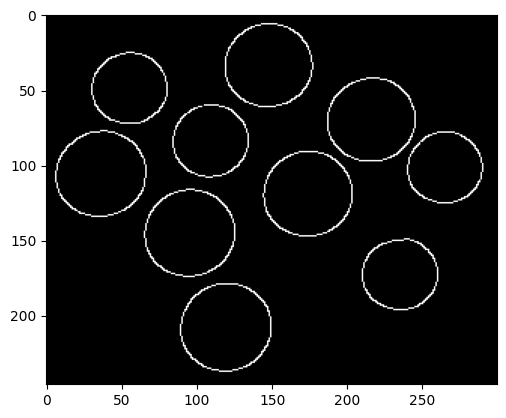

In [7]:
#Q1-2 (2)
# Convert the img from 32-bit float to 8-bit integer
coins_gray = cv2.normalize(coins_gray, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

# Apply Gaussian filter on the image first 
coins_gray_blurred = cv2.GaussianBlur(coins_gray, (5,5), 0)

# Built-in Canny edges detection
edge_coins = cv2.Canny(coins_gray_blurred, 200, 400)
edge_coins

plt.imshow(edge_coins, cmap = 'gray')

row = len(edge_coins)
col = len(edge_coins[0])

#normalization
for i in range(row):
    for j in range(col):
        edge_coins[i, j] /= 255


In [131]:
#Q1-3 
def hough_circle_acc(img, rad_l, rad_u, rad_inc, theta_inc):
    '''
    hough_circle_acc takes an img, lower/upper bounds of the radii (rad_l, rad_u), iteratively 
    increases the radii/theta by rad_inc and theta_inc, records and returns the number of votes in 
    an accumulator
    Requires: img is an edge-detected image (i.e., pixels that are detected as parts of an edge is 
    of value 1, otherwise 0)
    '''
    assert len(img) != 0
    row = len(img)
    col = len(img[0])
    rad = rad_l
    theta = 0
    n_rad = int(np.ceil((rad_u - rad_l) / rad_inc))
    count_rad = 0
    #build an accumulator 
    acc = np.zeros((row, col, n_rad+1))
    #iterate thr every pixel of img
    for i in range(row):  #O(row*col*(rad_u - rad + 1) * (2pi / theta_inc))
        for j in range(col):
            if img[i, j] == 1: #if the pixel is detected as a part of an edge 
                #keep increasing radii till the upper bound
                while rad <= rad_u:
                    #keep increasing the angle till 2pi
                    while theta < 2*np.pi:
                        #formulas followed
                        a = int(i - rad*np.cos(theta))
                        b = int(j - rad*np.sin(theta)) 
                        if (a >= 0) & (b >= 0) & (a < row) & (b < col):
                            acc[a, b, count_rad] += 1 #add a vote if in the range of the accumulator
                        theta += theta_inc
                    theta = 0
                    rad += rad_inc
                    count_rad += 1 #repeat the process with increasing radii
                rad = rad_l       
                count_rad = 0 #repeat the process with another pixel
            else:
                continue
    return acc



def hough_circle_transform(acc, img, rad_l, rad_u, rad_inc, thr):
    '''
    hough_circle_transform takes an accumulator and returns a list of coordinates sorted
    by the highest votes which their votes are at least as many as thr
    '''
    assert len(img) != 0
    n_rad = int(np.ceil((rad_u - rad_l) / rad_inc))
    row = len(img)
    col = len(img[0])
    max_votes = thr
    lst = []

    #Find the coord w/ the most votes
    for i in range(row):     
        for j in range(col):            
            for k in range(n_rad):  
                if acc[i, j, k] >= max_votes:
                    max_votes = acc[i, j, k]   #O(row*col*n_rad)

    #Add the coordinates to the returning list by decreasing votes, 
    #and ensure they are over the threshold votes
    while max_votes >= thr:
        for i in range(row):
            for j in range(col):
                for k in range(n_rad):
                    if acc[i, j, k] == max_votes:  #O((max_votes-thr)*row*col*n_rad)
                        lst += [[i, j, rad_l+rad_inc*k]] #[a, b, r]
        max_votes -= 1
    return lst
 

In [150]:
#Q1-3 , cont'd
row_coins = len(edge_coins)
col_coins = len(edge_coins[0])                  
rad_u = np.sqrt(row_coins**2 + col_coins**2)//2
print(rad_u)

coins_hough_acc = hough_circle_acc(edge_coins, 10, rad_u/4, 2, np.pi/90)

193.0


In [151]:
#Q1-3 , cont'd
coins_hough = hough_circle_transform(coins_hough_acc, edge_coins, 10, rad_u/4, 2, 70) 

coins_hough

[[101, 265, 24],
 [208, 119, 30],
 [101, 264, 24],
 [33, 148, 28],
 [146, 95, 30],
 [33, 147, 28],
 [207, 119, 30],
 [172, 235, 24],
 [69, 216, 28],
 [48, 55, 24],
 [83, 109, 24],
 [33, 146, 28],
 [48, 54, 24],
 [69, 217, 28],
 [83, 108, 24],
 [119, 172, 28],
 [145, 95, 30],
 [172, 234, 24],
 [107, 36, 30],
 [207, 118, 30],
 [118, 175, 28],
 [104, 35, 30],
 [144, 94, 30],
 [49, 54, 24],
 [117, 173, 30],
 [84, 108, 24],
 [106, 34, 28],
 [120, 174, 30],
 [48, 56, 24],
 [67, 215, 30],
 [69, 215, 28],
 [49, 55, 24],
 [83, 110, 24],
 [119, 175, 28],
 [172, 236, 24],
 [105, 37, 28],
 [69, 214, 28],
 [46, 54, 26],
 [34, 146, 28],
 [106, 36, 30],
 [81, 108, 26],
 [102, 264, 24],
 [118, 174, 28],
 [207, 121, 28],
 [31, 147, 30],
 [70, 215, 28],
 [101, 263, 24]]

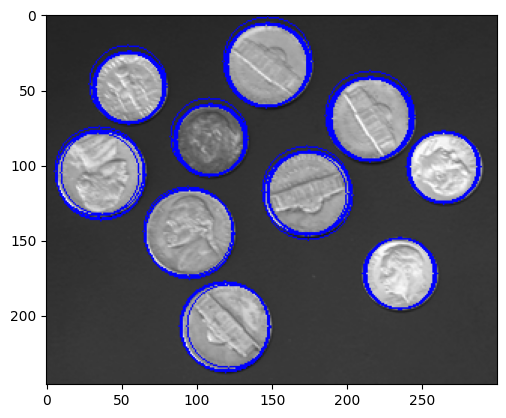

In [115]:
#Q1-3 , cont'd, visualization
coins = np.array(cv2.imread("./coins.png"))

leng_coins_hough = len(coins_hough)
#plot circles to coins.png
for i in range(leng_coins_hough):
    x = coins_hough[i][1]
    y = coins_hough[i][0]
    radius = coins_hough[i][2]
    cv2.circle(coins, (x, y), radius, (255, 0, 0) , 1)

coins = cv2.cvtColor(coins, cv2.COLOR_BGR2RGB)
plt.imshow(coins)


In [116]:
#Q1-3 , cont'd
row_smarties = len(edge_smarties)
col_smarties = len(edge_smarties[0])                  
rad_u_smarties = np.sqrt(row_smarties**2 + col_smarties**2)//2
print(rad_u_smarties)

smarties_hough_acc = hough_circle_acc(edge_smarties, 10, rad_u_smarties, 2, np.pi/90)

272.0


In [117]:
#Q1-3 , cont'd
smarties_hough = hough_circle_transform(smarties_hough_acc, edge_smarties, 10, rad_u_smarties, 2, 60)
smarties_hough

[[213, 287, 26],
 [228, 33, 26],
 [213, 286, 26],
 [210, 204, 26],
 [228, 32, 26],
 [320, 293, 28],
 [116, 269, 26],
 [271, 150, 28],
 [238, 346, 26],
 [116, 268, 26],
 [228, 34, 26],
 [318, 292, 26],
 [326, 133, 28],
 [327, 133, 28],
 [211, 204, 26],
 [80, 377, 26],
 [322, 295, 26],
 [82, 377, 26],
 [117, 268, 26],
 [213, 288, 26],
 [326, 135, 28],
 [306, 219, 28],
 [210, 205, 26],
 [303, 217, 26],
 [211, 205, 26],
 [169, 385, 26],
 [308, 221, 26],
 [169, 386, 26],
 [227, 32, 26],
 [258, 99, 28],
 [259, 99, 28],
 [212, 205, 26],
 [319, 294, 28],
 [321, 293, 28],
 [306, 220, 28],
 [326, 134, 28],
 [304, 221, 30],
 [80, 376, 26],
 [117, 269, 26],
 [118, 267, 26],
 [118, 269, 28],
 [236, 346, 28],
 [320, 292, 28],
 [210, 206, 28],
 [320, 294, 28],
 [325, 133, 26],
 [327, 134, 28],
 [81, 375, 28],
 [270, 152, 26],
 [304, 219, 28],
 [307, 219, 28],
 [326, 132, 28],
 [82, 377, 28],
 [169, 388, 28],
 [237, 348, 26],
 [318, 296, 30],
 [212, 204, 26],
 [318, 294, 28],
 [80, 378, 28],
 [272, 15

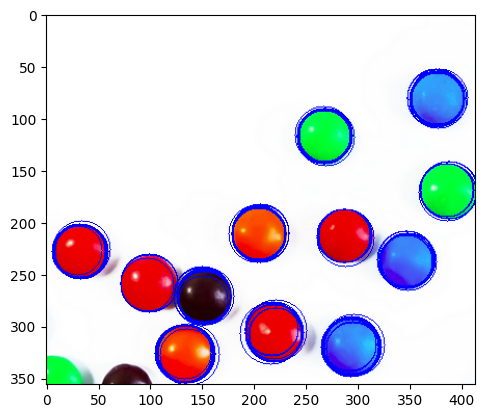

In [119]:
#Q1-3 , cont'd, visualization
smarties = np.array(cv2.imread("./smarties.png"))


leng_smarties_hough = len(smarties_hough)
#plot the circles to the smarties.png
for i in range(leng_smarties_hough):
    x = smarties_hough[i][1]
    y = smarties_hough[i][0]
    radius = smarties_hough[i][2]
    cv2.circle(smarties, (x, y), radius, (255, 0, 0) , 1)
    
smarties = cv2.cvtColor(smarties, cv2.COLOR_BGR2RGB)


plt.imshow(smarties)


In [157]:
#Q1-4

def non_max_sup (circle, thr):
    '''
    non_max_sup takes a list of coordinates (a, b, r) and threshold as input, and removes the coordinates which 
    are close to each other (euclidean distance for (a, b, r) <= thr) and not local maxima (with the most votes)
    '''
    circles = circle.copy()
    lst = []

    n_circles = len(circles)
    for i in range(n_circles): 
        for j in range(i+1, n_circles): #O(n^2)
            #compare the Euclidean Distance btwn the points and threshold
            if np.sqrt((circles[i][0] - circles[j][0])**2 + (circles[i][1] - circles[j][1])**2 + (circles[i][2] - circles[j][2])**2) <= thr:
                lst += [circles[j]] #if circles[i] is closed to circles[j], the latter is added to the removal list since it has lower votes

    #remove all those coordinates that are closed and w/ lower votes 
    for i in lst:
        if i in circles: #O(n^2)
            circles.remove(i)

    return circles

In [158]:
#Q1-4, cont'd
nms_coins = non_max_sup(coins_hough, 10)
nms_coins

[[101, 265, 24],
 [208, 119, 30],
 [33, 148, 28],
 [146, 95, 30],
 [172, 235, 24],
 [69, 216, 28],
 [48, 55, 24],
 [83, 109, 24],
 [119, 172, 28],
 [107, 36, 30]]

In [122]:
#Q1-4, cont'd
nms_smarties = non_max_sup(smarties_hough, 50)
nms_smarties

[[213, 287, 26],
 [228, 33, 26],
 [210, 204, 26],
 [320, 293, 28],
 [116, 269, 26],
 [271, 150, 28],
 [238, 346, 26],
 [326, 133, 28],
 [80, 377, 26],
 [306, 219, 28],
 [169, 385, 26],
 [258, 99, 28]]

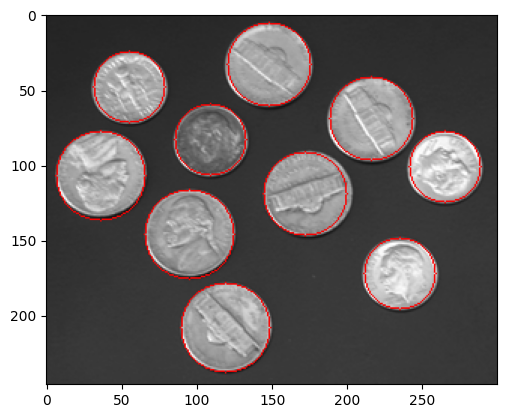

In [123]:
#Q1-5
coins = np.array(cv2.imread("./coins.png"))

leng_nms_coins = len(nms_coins) 
for i in range(leng_nms_coins):
    x = nms_coins[i][1]
    y = nms_coins[i][0]
    radius = nms_coins[i][2]
    cv2.circle(coins, (x, y), radius, (0, 0, 255) , 1)

coins = cv2.cvtColor(coins, cv2.COLOR_BGR2RGB)
#plot the coins image after non-max suppresion
plt.imshow(coins)

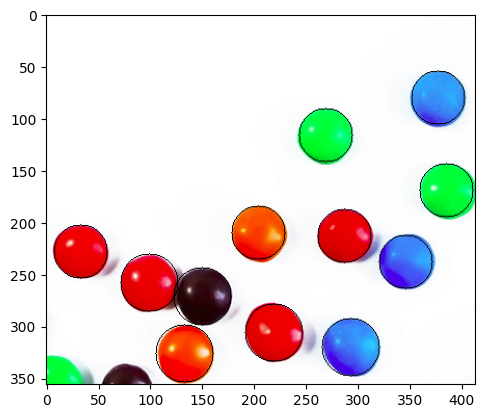

In [124]:
#Q1-5

smarties = np.array(cv2.imread("./smarties.png"))

leng_nms_smarties = len(nms_smarties)
for i in range(leng_nms_smarties):
    x = nms_smarties[i][1]
    y = nms_smarties[i][0]
    radius = nms_smarties[i][2]
    cv2.circle(smarties, (x, y), radius, (0, 0, 0), 1)

smarties = cv2.cvtColor(smarties, cv2.COLOR_BGR2RGB)
#plot the smarties image after non-max suppresion
plt.imshow(smarties)